# IOT Assignment 2

###### Submitted by: 
        Jason Koh (1846614)
        Kobin Fong (1846573)
        Tao Daniel (1827918)


- [Initial Download](#initial)
- [Importing Libraries](#libimport)
- [Exploratory Data Analysis](#eda)
- [Cleaning the Data](#clean)
- [Saving Cleaned Data](#saveclean)
- [Feature Engineering](#feateng)
- [Modeling & Evaluating Model(s)](#model)
- [Saving the Model](#save)
- [Method for Integration with Flask](#inter)
- [References](#ref)


<a id="initial"></a>

# Initial Download

- Install the following dependencies to get dataset

- For initial load only

### Data Retrieval

<a id="libimport"></a>
# Importing Libraries

In [1]:
import warnings
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 500)

# formatting
pd.options.display.float_format = '{:20,.2f}'.format 

# disable warnings:
import warnings
warnings.simplefilter("ignore")

message="        Versions        "
print("*"*len(message))
print(message)
print("*"*len(message))
print("Numpy version={}".format(np.__version__))
print("Pandas version={}".format(pd.__version__))

************************
        Versions        
************************
Numpy version=1.18.1
Pandas version=1.0.1


### Data Importing

In [2]:
#initial loading of dataset

FILES = dict ([(f, None) for f in os.listdir ('ds/original')])
df = pd.DataFrame()

for count, file in enumerate(FILES):
    if "feature" in file:
        buf = pd.read_csv(f"./ds/original/{file}")
        df = pd.concat([df,buf])
    elif "label" in file:
        labels = pd.read_csv(f"./ds/original/{file}")

<a id="eda"></a>
# Exploratory Data Analysis

### Data Visualisation - Correlation Matrix

- Use the heatmap function from seaborn to plot the correlation matrix <br>
- Annot = True to print the values inside the square

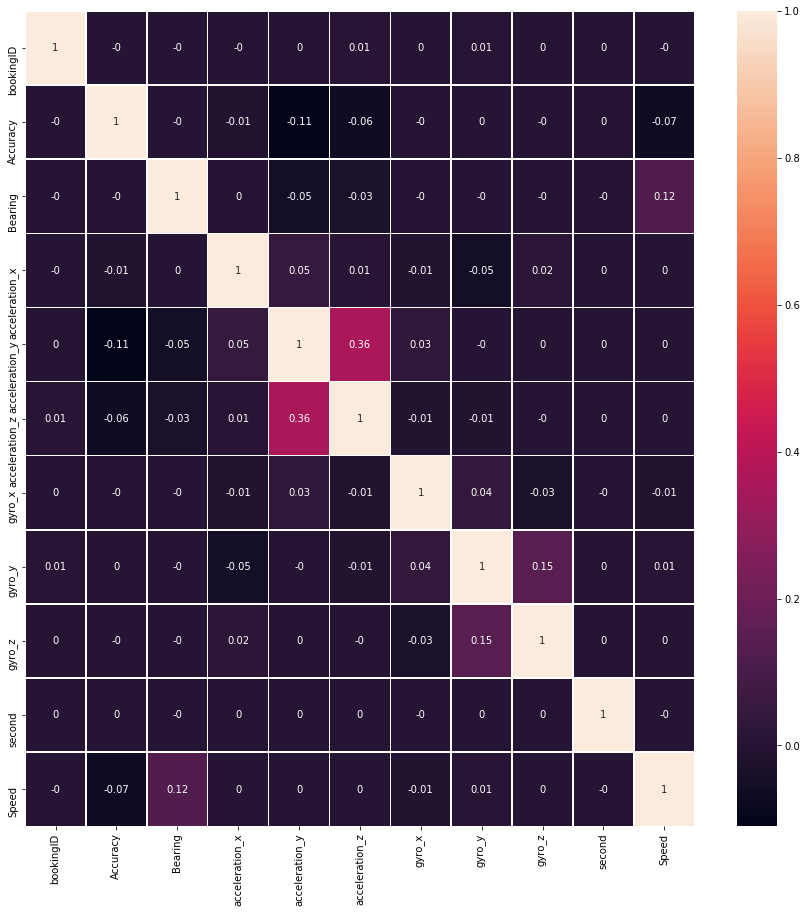

In [3]:
correlation_matrix = df.corr().round(2)

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

In [4]:
#Length of Features dataset

len(df)

16135561

In [5]:
#Length of Labels dataset

len(labels)

20018

In [6]:
#Check if there are missing features data

print("List of missing features data: ")
df.isnull().sum()

List of missing features data: 


bookingID         0
Accuracy          0
Bearing           0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
second            0
Speed             0
dtype: int64

In [7]:
#check if there are missing label data
print("List of missing label data: ")
labels.isnull().sum()

List of missing label data: 


bookingID    0
label        0
dtype: int64

In [8]:
print("List of missing features data: ")
df.isnull().sum()

List of missing features data: 


bookingID         0
Accuracy          0
Bearing           0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
second            0
Speed             0
dtype: int64

In [9]:
#check data types
print("Features Data Types: ")
df.dtypes

Features Data Types: 


bookingID           int64
Accuracy          float64
Bearing           float64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
second            float64
Speed             float64
dtype: object

<a id="clean"></a>
# Data Preparation

1. Remove duplicated Booking IDs from features and labels
2. Sorting the data sets consecutively according to their timestamp to compare "seconds" record.
3. Handling inaccurate records
    - records with duration of more than 2 hours are removed, if
    their seconds column are not continous
4. Handling trips with missing records
    - Remove if trips have too many missing data for the duration of the trip
5. Replace negative speed (impossible) to reflect missing data


### 1. Checking for duplicate labels

In [10]:
print("Number of unique labels: ", len(labels.bookingID.value_counts()))
print("Total number of records in labels: ", len(labels))

Number of unique labels:  20000
Total number of records in labels:  20018


In [11]:
# check the duplicate labels
duplicates = pd.concat(x for _,x in labels.groupby("bookingID") if len(x)>1)
print("Number of duplicate bookingids: ", len(duplicates))
duplicates.drop_duplicates()

Number of duplicate bookingids:  36


,bookingID,label
12463,13,0
12602,13,1
2351,154618822837,1
5295,154618822837,0
6212,223338299461,0
11215,223338299461,1
6121,395136991308,1
19936,395136991308,0
8472,403726925929,0
17623,403726925929,1


- There are duplicate labels in labels dataset

In [12]:
# remove duplicates from labels, since 1 bookingID should not have 2 labels.

cleaned_labels = labels[~labels.bookingID.isin(duplicates.bookingID)].copy()
print("Number of cleaned labels:", len(cleaned_labels))

Number of cleaned labels: 19982


#### Now need to remove duplicate bookingids from features

In [13]:
# Next will be to remove duplicate bookingids from features, but first, need to sort features and aggregate the features.
cleaned_df = df[~df.bookingID.isin(duplicates.bookingID)].copy()

# number of rows removed for duplicate bookingids
print("Number of rows removed for all the duplicate bIDs: \n", len(df) - len(cleaned_df))

Number of rows removed for all the duplicate bIDs: 
 18857


In [14]:
# Group By Booking ID, Sort by Time

sorted_df = cleaned_df.sort_values(['bookingID','second']).copy()
sorted_df.head(10)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
1153972,0,12.00,143.30,0.82,-9.94,-2.01,-0.02,-0.09,0.07,0.00,3.44
712971,0,8.00,143.30,0.55,-9.84,-2.04,-0.05,-0.08,0.04,1.00,0.23
167611,0,8.00,143.30,-1.71,-9.27,-1.21,-0.03,-0.03,0.02,2.00,0.23
436147,0,8.00,143.30,-1.42,-9.55,-1.86,-0.02,0.01,-0.03,3.00,0.23
1423207,0,8.00,143.30,-0.60,-9.85,-1.38,-0.01,-0.05,0.02,4.00,0.23
357335,0,8.00,143.30,-0.61,-9.54,-1.79,-0.01,-0.02,0.02,5.00,0.23
1413389,0,8.00,143.30,-0.87,-9.70,-1.62,0.02,-0.01,0.01,6.00,0.23
767009,0,8.00,143.30,-1.05,-9.75,-1.41,0.03,0.00,0.00,7.00,0.23
1312324,0,8.00,143.30,-0.72,-9.96,-1.20,0.00,-0.01,0.01,8.00,0.23
945598,0,8.00,143.30,-0.35,-9.53,-1.20,0.01,-0.05,0.03,9.00,0.23


In [15]:
## check number of records per booking id
sorted_df.groupby('bookingID').count().head()

,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
bookingID,,,,,,,,,,
0,1004,1004,1004,1004,1004,1004,1004,1004,1004,1004
1,851,851,851,851,851,851,851,851,851,851
2,195,195,195,195,195,195,195,195,195,195
4,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094
6,1095,1095,1095,1095,1095,1095,1095,1095,1095,1095


### 2. Handling inaccurate records
- Remove outlier record that has duration (seconds) >= 10000 and are not continous with the preceding records

In [16]:
# removing inaccurate seconds records
df_seconds = sorted_df.copy()

In [17]:
# check the seconds column for records with excessively long duration
sorted_df.groupby('bookingID').agg('max').sort_values(by='second', ascending=False).head(10)

,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
bookingID,,,,,,,,,,
1503238553722,44.10,359.00,3.92,12.80,0.48,0.30,0.31,0.14,"1,495,796,757.00",19.44
1460288880770,9.39,359.00,3.68,12.41,3.52,1.29,2.69,0.75,"619,316,568.00",26.95
858993459333,49.49,358.00,2.85,11.58,15.85,0.19,0.50,0.24,"619,315,993.00",21.06
1434519076976,32.38,359.00,4.02,14.02,10.19,0.95,6.11,0.57,"619,315,595.00",25.15
1108101562401,13.42,359.00,2.60,10.89,8.15,0.52,0.96,0.47,"619,315,523.00",18.17
438086664371,35.60,359.00,18.22,29.35,19.09,5.34,9.01,5.50,"8,235.00",20.43
532575944853,9.32,356.00,3.62,11.52,7.35,0.35,0.56,0.24,"7,355.00",16.00
446676598869,22.60,359.00,2.31,11.56,5.89,0.38,1.58,0.75,"5,988.00",27.29
1374389534819,"2,000.00",359.85,4.05,-4.26,3.71,1.63,1.19,0.54,"4,499.00",25.53


Exclude trips that took longer than 2 hours. 

Trips in Singapore probably will not take longer than 2 hours.

In [18]:
# further individual analysis
df_seconds[df_seconds.bookingID==1503238553722].tail(10)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
156556,1503238553722,3.90,325.00,0.78,8.66,-2.20,0.01,-0.00,0.02,396.00,18.41
903053,1503238553722,3.90,325.00,1.83,8.57,-0.79,-0.01,-0.02,0.00,397.00,18.24
744706,1503238553722,3.90,325.00,0.94,8.47,-1.83,-0.03,-0.00,0.00,398.00,18.19
1212988,1503238553722,3.90,326.00,0.19,9.35,-2.39,-0.00,-0.00,-0.01,399.00,18.39
787523,1503238553722,3.90,326.00,0.18,9.09,-1.99,-0.00,0.00,-0.00,400.00,18.58
484514,1503238553722,3.90,326.00,0.46,10.00,-2.19,0.01,0.00,0.00,401.00,18.77
332034,1503238553722,3.90,326.00,0.48,10.04,-2.18,-0.00,0.01,-0.00,402.00,18.83
10303,1503238553722,3.22,325.00,-0.06,9.65,-2.10,-0.01,0.01,0.02,403.00,19.16
1299210,1503238553722,3.90,324.00,0.17,10.08,-1.96,-0.00,0.02,0.02,404.00,19.44
1084533,1503238553722,30.64,0.00,0.33,9.64,-1.97,-0.01,0.01,0.00,"1,495,796,757.00",0.00


Removing the outlier record of > 2 hour as the preceding record has too large a gap.

Other records values seem to be consistent in terms of duration

In [19]:
# removing the outlier record
cleaned_df = sorted_df[sorted_df.second<=10000].reset_index(drop=True).copy()

# clearing the analysis dataframe
df_seconds = df_seconds[0:0] 
sorted_df = sorted_df[0:0]

In [20]:
cleaned_df[cleaned_df.bookingID==1503238553722].tail(10)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
14455522,1503238553722,3.90,325.00,0.96,9.86,-1.60,0.00,-0.00,0.00,395.00,18.41
14455523,1503238553722,3.90,325.00,0.78,8.66,-2.20,0.01,-0.00,0.02,396.00,18.41
14455524,1503238553722,3.90,325.00,1.83,8.57,-0.79,-0.01,-0.02,0.00,397.00,18.24
14455525,1503238553722,3.90,325.00,0.94,8.47,-1.83,-0.03,-0.00,0.00,398.00,18.19
14455526,1503238553722,3.90,326.00,0.19,9.35,-2.39,-0.00,-0.00,-0.01,399.00,18.39
14455527,1503238553722,3.90,326.00,0.18,9.09,-1.99,-0.00,0.00,-0.00,400.00,18.58
14455528,1503238553722,3.90,326.00,0.46,10.00,-2.19,0.01,0.00,0.00,401.00,18.77
14455529,1503238553722,3.90,326.00,0.48,10.04,-2.18,-0.00,0.01,-0.00,402.00,18.83
14455530,1503238553722,3.22,325.00,-0.06,9.65,-2.10,-0.01,0.01,0.02,403.00,19.16
14455531,1503238553722,3.90,324.00,0.17,10.08,-1.96,-0.00,0.02,0.02,404.00,19.44


### 3. Removing Inaccurate Trips
- Trips which have most of their data missing

In [21]:
# find % missing
# % of count over maximum second of each trip 
features_agg = cleaned_df.groupby('bookingID')['second'].agg(['min','max','count'])
features_agg['perc_available'] = features_agg['count'] / (features_agg['max'] - features_agg['min'] + 1)

print('max value of max seconds :')
print(max(features_agg['max']))
print('max value of count of records :')
print(max(features_agg['count']))

max value of max seconds :
8235.0
max value of count of records :
7561


In [22]:
# Trips lasting more than an hour 
features_agg[features_agg['max'] > 3600]

,min,max,count,perc_available
bookingID,,,,
34359738469,0.00,"4,305.00",4302,1.00
60129542174,0.00,"3,688.00",434,0.12
438086664371,0.00,"8,235.00",7561,0.92
446676598842,0.00,"3,614.00",259,0.07
446676598869,0.00,"5,988.00",542,0.09
532575944853,0.00,"7,355.00",135,0.02
747324309632,0.00,"3,689.00",3674,1.00
833223655429,0.00,"3,928.00",2696,0.69
893353197656,0.00,"4,064.00",3486,0.86


In [23]:
perc_check = 0.5
print("There are only {} records with more than {}% of the trips missing.".format(len(features_agg[features_agg['perc_available']<perc_check]), (1-perc_check)*100))

There are only 781 records with more than 50.0% of the trips missing.


In [24]:
high_perc_missing = features_agg[features_agg.perc_available < perc_check].index

In [25]:
df_removed50perc = cleaned_df[~cleaned_df.bookingID.isin(high_perc_missing)].copy()
labels_removed50perc = cleaned_labels[~cleaned_labels.bookingID.isin(high_perc_missing)]

In [26]:
print(len(cleaned_df) - len(df_removed50perc), "records removed because missing >50% of the trip.")
# We may or may not use this removed50perc.

273165 records removed because missing >50% of the trip.


In [27]:
df_removed50perc.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,12.00,143.30,0.82,-9.94,-2.01,-0.02,-0.09,0.07,0.00,3.44
1,0,8.00,143.30,0.55,-9.84,-2.04,-0.05,-0.08,0.04,1.00,0.23
2,0,8.00,143.30,-1.71,-9.27,-1.21,-0.03,-0.03,0.02,2.00,0.23
3,0,8.00,143.30,-1.42,-9.55,-1.86,-0.02,0.01,-0.03,3.00,0.23
4,0,8.00,143.30,-0.60,-9.85,-1.38,-0.01,-0.05,0.02,4.00,0.23


#### Analysing Missing Data
- Visualising a single booking ID's missing trip data

23741                   0.00
23742                  40.00
23743                  60.00
23744                  67.00
23745                  69.00
Name: second, dtype: float64


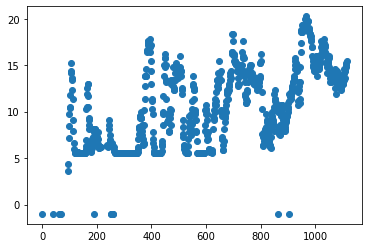

In [28]:
id = 47
print(cleaned_df[cleaned_df.bookingID == id].second.head())
plt.scatter(cleaned_df[cleaned_df.bookingID == id].second,
            cleaned_df[cleaned_df.bookingID == id].Speed 
           )
ls = list(cleaned_df[cleaned_df.bookingID == id].second.astype('int'))

### 4. Cleaning missing records in a trip

#### To identify bookingIDs which should be removed

**Criteria**
- If the number of missing values is > 5
- If the number of missing values is within +-5 of the range of missing values

In [29]:
def missing_elements(L):
    """
    Finds the missing elements given a list L. 
    """
    start, end = L[0], L[-1]
    return sorted(set(range(start, end + 1)).difference(L))

from itertools import groupby
from operator import itemgetter
def getConsecMissingLength(ls, length_only=True):
    """
    Input: list of integers 
        length_only (default True) to return only the length of consecutive missing
    Output: list of consecutive missing numbers (length_only=False) 
        OR list of length of each consecutive missing (length_only=True; default)
    """    
    results = []
    for k, g in groupby(enumerate(ls), lambda ix : ix[0] - ix[1]):
        if length_only:
            results.append(len(list(map(itemgetter(1),g))))
        else:
            results.append(list(map(itemgetter(1), g)))
    return results

In [30]:
# threshold for consecutive missing numbers
# anything >= this threshold is too much and should not be imputed.

window = 5

In [31]:
# Creating a dataframe to look specifically at the seconds data
df_t = cleaned_df.copy() # df_removed50perc.copy()
df_t['second'] = df_t['second'].astype('int')
df_s = pd.DataFrame(df_t.groupby('bookingID')['second'].apply(list))

# Creating columns
df_s['missing'] = df_s['second'].apply(missing_elements)
df_s['missingCount'] = df_s['missing'].str.len()
df_s['missingRange'] = (df_s['missing'].str[-1] - df_s['missing'].str[0])
df_s['missingNumbersDelta'] = df_s['missing'].apply(getConsecMissingLength)

# Reducing the size of the dataframe to only those with 5 or more missing values.
df_m = df_s[df_s.missingCount >= window]
df_m['MaxDelta'] = list(map(max, df_m['missingNumbersDelta'])) # get the maximum of the Delta

In [32]:
#df_s.head(10)

In [33]:
#df_m.head(20)

In [34]:
print("""
Out of {} bookingIDs after first round of cleaning:
{} bookingIDs have no missing values.
{} bookingIDs have missing values < 5 missing values (can be imputed).

Out of the remaining {} bookingIDs with 5 or more missing values, {} have 5 or more consecutive missing values that cannot be reliably imputed (should be removed).
""".format(len(df_s), 
           len(df_s[df_s.missingCount == 0]),
           len(df_s[(df_s.missingCount < window) & (df_s.missingCount > 0)]),
           len(df_m),
           len(df_m[df_m.MaxDelta>=window])
          ))


Out of 19982 bookingIDs after first round of cleaning:
4968 bookingIDs have no missing values.
3245 bookingIDs have missing values < 5 missing values (can be imputed).

Out of the remaining 11769 bookingIDs with 5 or more missing values, 8973 have 5 or more consecutive missing values that cannot be reliably imputed (should be removed).



In [35]:
# get the bookingIDs 
to_impute = df_s[df_s.missingCount < window].index
to_impute = to_impute.append(df_m[df_m.MaxDelta < window].index)
to_remove = df_m[df_m.MaxDelta >= window].index

# print(len(to_impute), len(to_remove)) # checking

In [36]:
# removing bookingIDs with too much consecutive missing information 
cleaned_df = df_removed50perc[~df_removed50perc.bookingID.isin(to_remove)]
cleaned_labels = labels_removed50perc[~labels_removed50perc.bookingID.isin(to_remove)]
cleaned_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
2050,4,10.00,57.71,-0.69,-9.18,-3.63,-0.02,0.11,-0.09,0.00,7.99
2051,4,10.00,57.71,-0.58,-8.91,-3.19,-0.03,0.01,0.00,1.00,5.17
2052,4,10.00,57.71,-0.59,-9.35,-2.68,0.01,0.08,-0.03,2.00,4.09
2053,4,10.00,57.71,-0.48,-9.21,-3.37,-0.01,0.01,0.05,3.00,3.72
2054,4,10.00,57.71,-0.32,-9.19,-3.18,-0.03,0.07,-0.03,4.00,3.72


In [37]:
print("After removing:", len(cleaned_df),"records with", len(cleaned_df.bookingID.unique()),"unique bookingIDs.") 

After removing: 8485718 records with 11007 unique bookingIDs.


### 5. Changing Negative Speed to reflect missing data

In [38]:
cleaned_df.loc[cleaned_df['Speed'] < 0, 'Speed']  = np.NaN
cleaned_df.loc[pd.isna(cleaned_df.Speed) & (cleaned_df['Bearing'] == 0), 'Bearing'] = np.NaN

print("Total number of Speed and Bearing NaN values:")
cleaned_df[['Bearing', 'Speed']].isna().sum()

Total number of Speed and Bearing NaN values:


Bearing     16163
Speed      131323
dtype: int64

### 6. Creating the Index of the dataframe with Datetime

In order to have the rows correspond to a specific timestamp, a datetime column is created and set as the index. 

In [39]:
len(cleaned_df)

8485718

In [40]:
cleaned_df = cleaned_df[cleaned_df.bookingID.isin(to_impute)]

In [41]:
cleaned_df['date'] = pd.to_datetime(cleaned_df['second'], unit='s')
cleaned_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,date
2050,4,10.00,57.71,-0.69,-9.18,-3.63,-0.02,0.11,-0.09,0.00,7.99,1970-01-01 00:00:00
2051,4,10.00,57.71,-0.58,-8.91,-3.19,-0.03,0.01,0.00,1.00,5.17,1970-01-01 00:00:01
2052,4,10.00,57.71,-0.59,-9.35,-2.68,0.01,0.08,-0.03,2.00,4.09,1970-01-01 00:00:02
2053,4,10.00,57.71,-0.48,-9.21,-3.37,-0.01,0.01,0.05,3.00,3.72,1970-01-01 00:00:03
2054,4,10.00,57.71,-0.32,-9.19,-3.18,-0.03,0.07,-0.03,4.00,3.72,1970-01-01 00:00:04


In [42]:
cleaned_df.set_index('date', inplace = True) 
cleaned_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
date,,,,,,,,,,,
1970-01-01 00:00:00,4,10.00,57.71,-0.69,-9.18,-3.63,-0.02,0.11,-0.09,0.00,7.99
1970-01-01 00:00:01,4,10.00,57.71,-0.58,-8.91,-3.19,-0.03,0.01,0.00,1.00,5.17
1970-01-01 00:00:02,4,10.00,57.71,-0.59,-9.35,-2.68,0.01,0.08,-0.03,2.00,4.09
1970-01-01 00:00:03,4,10.00,57.71,-0.48,-9.21,-3.37,-0.01,0.01,0.05,3.00,3.72
1970-01-01 00:00:04,4,10.00,57.71,-0.32,-9.19,-3.18,-0.03,0.07,-0.03,4.00,3.72


<a id="saveclean"></a>

# Saving Cleaned Data

In [43]:
import pickle

In [44]:
#Saving

# saving cleaned labels
cleaned_labels.to_csv("./ds/labels/cleaned_labels.csv")

# saving sorted features
cleaned_df.to_pickle("./ds/features/cleaned_features.pkl")

In [45]:
# uncomment to load to save time

cleaned_df = pickle.load(open("./ds/features/cleaned_features.pkl",'rb'))
cleaned_labels = pd.read_csv("./ds/labels/cleaned_labels.csv", index_col=0)

In [46]:
print("Total number of records: ", len(cleaned_df), "\n")

cleaned_df.info(memory_usage='deep')

Total number of records:  8485718 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8485718 entries, 1970-01-01 00:00:00 to 1970-01-01 00:17:59
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   bookingID       int64  
 1   Accuracy        float64
 2   Bearing         float64
 3   acceleration_x  float64
 4   acceleration_y  float64
 5   acceleration_z  float64
 6   gyro_x          float64
 7   gyro_y          float64
 8   gyro_z          float64
 9   second          float64
 10  Speed           float64
dtypes: float64(10), int64(1)
memory usage: 776.9 MB


<a id="feateng"></a>
# Feature Engineering

In [47]:
def dispersion(s):
    # calculate range
    return s.max() - s.min()

In [48]:
# required column names
COL_ACCE = ('acceleration_x', 'acceleration_y', 'acceleration_z')
COL_GYRO = ('gyro_x', 'gyro_y', 'gyro_z')
COL_TELE = ('bookingID', 'Accuracy', 'Bearing', 'second', 'Speed', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z')
    
bid = cleaned_df.bookingID.unique()

In [49]:
# Data Validation 

if not sorted(cleaned_df.columns) == sorted(COL_TELE):
    raise Exception('Input columns mismatched! Expected: \n {}'.format(COL_TELE))
     
# sort according to bookingID & seconds
df_use = cleaned_df.sort_values(['bookingID', 'second']).reset_index(drop=True)
    
# drop 'Accuracy' & 'Bearing' to save memory. we don't need these anymore. 
df_use.drop(['Accuracy', 'Bearing'], axis=1, inplace=True)

In [50]:
df_use.head()

,bookingID,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,4,-0.69,-9.18,-3.63,-0.02,0.11,-0.09,0.00,7.99
1,4,-0.58,-8.91,-3.19,-0.03,0.01,0.00,1.00,5.17
2,4,-0.59,-9.35,-2.68,0.01,0.08,-0.03,2.00,4.09
3,4,-0.48,-9.21,-3.37,-0.01,0.01,0.05,3.00,3.72
4,4,-0.32,-9.19,-3.18,-0.03,0.07,-0.03,4.00,3.72


In [52]:
# transform triaxial gyro readings into its first principal components
from sklearn.decomposition import PCA

pca_gyro = PCA().fit(df_use.loc[:, ['gyro_x', 'gyro_y', 'gyro_z']])
pca_gyro.explained_variance_ratio_

array([0.68031479, 0.16824603, 0.15143918])

#### Calculating Acceleration

In [53]:
# Data Transformation
    
# calculate magnitude of acceleration sqrt(acc_x^2 + acc_y^2 + acc_z^2)

df_use['acceleration'] = np.sqrt((df_use.loc[:, COL_ACCE] ** 2).sum(axis=1))
    
df_use['gyro'] = pca_gyro.transform(df_use.loc[:, COL_GYRO])[:,0]

In [54]:
df_use.head(20)

,bookingID,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,acceleration,gyro
0,4,-0.69,-9.18,-3.63,-0.02,0.11,-0.09,0.00,7.99,9.90,-0.09
1,4,-0.58,-8.91,-3.19,-0.03,0.01,0.00,1.00,5.17,9.48,-0.01
2,4,-0.59,-9.35,-2.68,0.01,0.08,-0.03,2.00,4.09,9.74,-0.07
3,4,-0.48,-9.21,-3.37,-0.01,0.01,0.05,3.00,3.72,9.82,-0.02
4,4,-0.32,-9.19,-3.18,-0.03,0.07,-0.03,4.00,3.72,9.73,-0.06
5,4,-0.40,-10.13,-0.36,-0.03,-0.08,0.00,6.00,1.18,10.15,0.08
6,4,-0.37,-9.10,-1.84,-0.07,0.02,-0.00,7.00,1.18,9.29,-0.02
7,4,-0.32,-8.95,-3.01,-0.03,0.02,-0.00,8.00,1.18,9.45,-0.02
8,4,-0.43,-9.41,-2.34,-0.00,-0.05,-0.02,9.00,2.43,9.71,0.06
9,4,-0.24,-9.12,-2.16,-0.05,-0.18,-0.02,10.00,2.43,9.37,0.19


In [55]:
# Aggregating the features
    
feature1 = df_use.groupby('bookingID')['acceleration', 'gyro', 'Speed', 'second'].agg(['mean', 'median', 'std', dispersion]).fillna(0)
#feature1 = df_use.groupby('bookingID')['acceleration_x','acceleration_y','acceleration_z', 'gyro_x','gyro_y','gyro_z', 'Speed', 'second'].agg(['mean', 'median', 'std', dispersion]).fillna(0)
feature1.columns = ['_'.join(col) for col in feature1.columns] # rename columns
feature1.reset_index(inplace=True)

In [56]:
feature1.head()

,bookingID,acceleration_mean,acceleration_median,acceleration_std,acceleration_dispersion,gyro_mean,gyro_median,gyro_std,gyro_dispersion,Speed_mean,Speed_median,Speed_std,Speed_dispersion,second_mean,second_median,second_std,second_dispersion
0,4,9.81,9.79,0.62,13.35,-0.02,-0.02,0.11,1.16,6.15,3.31,5.60,19.78,547.50,547.50,315.96,"1,094.00"
1,6,9.92,9.90,0.59,7.28,0.00,-0.00,0.11,1.16,4.63,1.94,5.31,16.39,547.00,547.00,316.24,"1,094.00"
2,7,9.83,9.79,0.92,8.57,0.00,0.00,0.07,0.83,12.18,13.02,8.68,25.23,480.95,481.00,276.76,959.00
3,10,9.55,9.49,0.83,9.47,0.00,0.00,0.11,0.88,8.70,9.58,7.00,20.05,187.00,187.00,108.40,374.00
4,14,9.86,9.82,0.45,6.11,0.01,0.00,0.09,0.93,4.74,3.24,4.57,20.70,299.50,299.50,173.35,599.00


In [57]:
output = pd.DataFrame(bid, columns=['bookingID'])
output = output.merge(feature1, how='left', on='bookingID')

In [58]:
output = output.merge(cleaned_labels, how='left', on='bookingID')
output.head()

,bookingID,acceleration_mean,acceleration_median,acceleration_std,acceleration_dispersion,gyro_mean,gyro_median,gyro_std,gyro_dispersion,Speed_mean,Speed_median,Speed_std,Speed_dispersion,second_mean,second_median,second_std,second_dispersion,label
0,4,9.81,9.79,0.62,13.35,-0.02,-0.02,0.11,1.16,6.15,3.31,5.60,19.78,547.50,547.50,315.96,"1,094.00",1
1,6,9.92,9.90,0.59,7.28,0.00,-0.00,0.11,1.16,4.63,1.94,5.31,16.39,547.00,547.00,316.24,"1,094.00",0
2,7,9.83,9.79,0.92,8.57,0.00,0.00,0.07,0.83,12.18,13.02,8.68,25.23,480.95,481.00,276.76,959.00,0
3,10,9.55,9.49,0.83,9.47,0.00,0.00,0.11,0.88,8.70,9.58,7.00,20.05,187.00,187.00,108.40,374.00,0
4,14,9.86,9.82,0.45,6.11,0.01,0.00,0.09,0.93,4.74,3.24,4.57,20.70,299.50,299.50,173.35,599.00,0


In [59]:
output.dtypes

bookingID                    int64
acceleration_mean          float64
acceleration_median        float64
acceleration_std           float64
acceleration_dispersion    float64
gyro_mean                  float64
gyro_median                float64
gyro_std                   float64
gyro_dispersion            float64
Speed_mean                 float64
Speed_median               float64
Speed_std                  float64
Speed_dispersion           float64
second_mean                float64
second_median              float64
second_std                 float64
second_dispersion          float64
label                        int64
dtype: object

<a id="model"></a>
# Modeling & Evaluating the Model(s)

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import classification_report, roc_curve, confusion_matrix, accuracy_score, roc_auc_score, auc
from sklearn import preprocessing

import scikitplot as skplt



### 1. Splitting the data

In [61]:
labels = output['label']
train = output.drop(['bookingID','label'],axis=1)

x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, random_state=2)

In [62]:
print(x_train.shape)
print(x_test.shape)

(8805, 16)
(2202, 16)


In [63]:
clf = GradientBoostingClassifier(n_estimators=50, max_features='sqrt', random_state=180)
clf = clf.fit(x_train, y_train)

### 2. Analysing Importance

In [64]:
#analyse importance of features
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

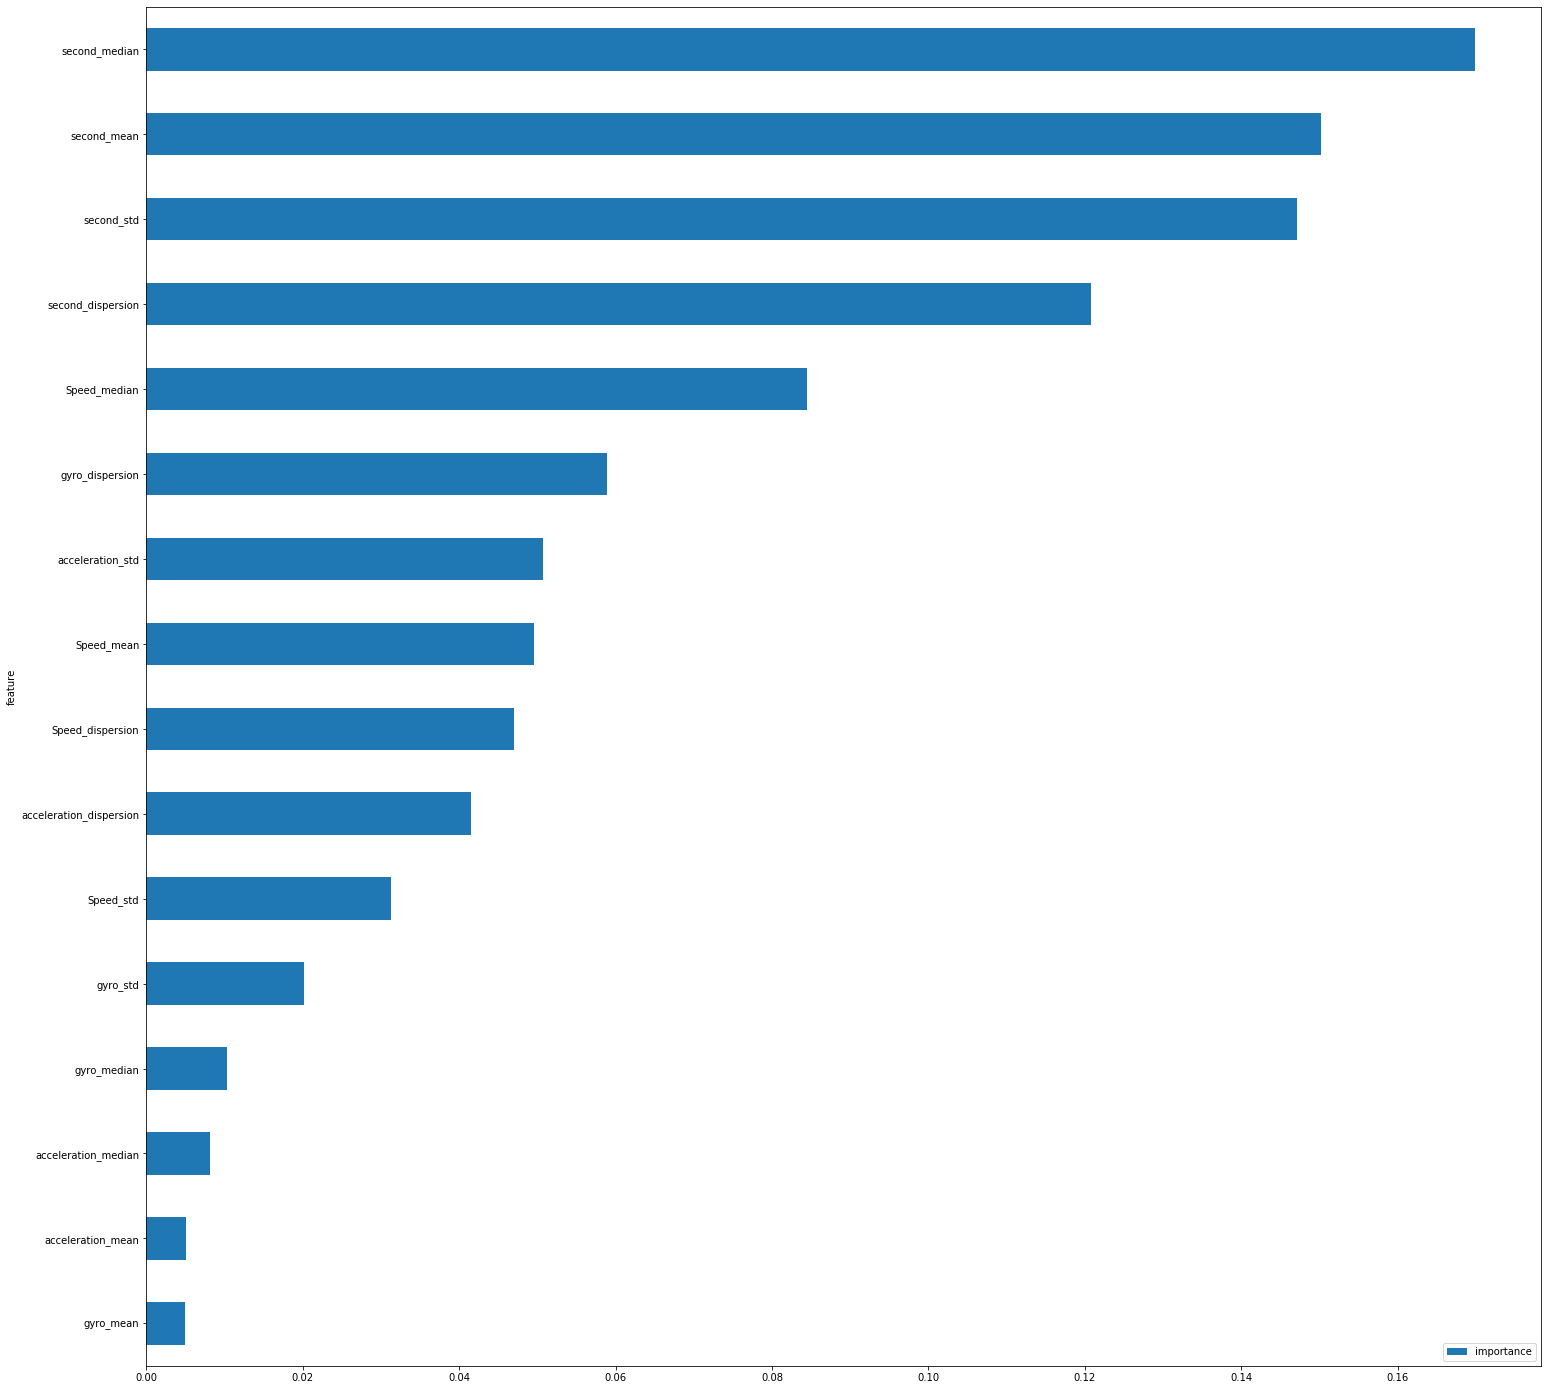

In [65]:
features.plot(kind='barh', figsize=(25, 25))

In [66]:
#model = SelectFromModel(clf, prefit=True, threshold=0.0198)
model = SelectFromModel(clf, prefit=True, threshold=0)

x_train_reduced = model.transform(x_train)
print(x_train_reduced.shape)

(8805, 16)


In [67]:
x_test_reduced = model.transform(x_test)
print(x_test_reduced.shape)

(2202, 16)


### 3. Cross-validation

- Commented out this section. Used only while building the model

In [68]:
#gradient boosting classifier
#hyperparameters tuning

'''
model = GradientBoostingClassifier(criterion='friedman_mse', 
                                   learning_rate=0.1, loss='deviance', max_depth=3,
                                   max_features='sqrt',
                                   min_samples_leaf=1, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=50,
                                   random_state=180,
                                   verbose=1) 
'''

model = GradientBoostingClassifier(n_estimators=50, max_features='sqrt', random_state=180)

#Training the model (using reduced Train set)
x_train = x_train_reduced
x_test = x_test_reduced

model.fit(x_train, y_train)

#Predict the results of the test set
y_predict = model.predict(x_test)

In [69]:
print('Training score: {}'.format(model.score(x_train, y_train)))
print('Test score: {}'.format(model.score(x_test, y_test)))

Training score: 0.8400908574673481
Test score: 0.8278837420526793


In [70]:
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_predict))
print('\n')



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1787
           1       0.75      0.13      0.22       415

    accuracy                           0.83      2202
   macro avg       0.79      0.56      0.56      2202
weighted avg       0.82      0.83      0.77      2202





- For every 100 driving trips that are predicted to be safe, 83 cases are correct
- For every 100 driving trips that are predicted to be dangerous, 75 cases are correct

True positive =  1769
False positive =  18
False negative =  361
True negative =  54


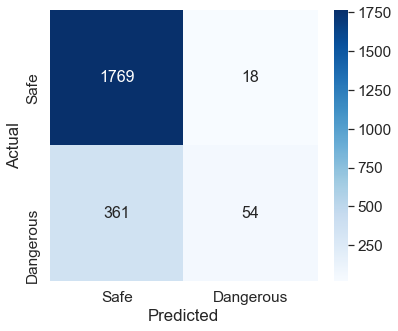

In [71]:
#model accuracy
class_names=["Safe","Dangerous"]
cm = confusion_matrix(y_test, y_predict, labels=[0,1])
df_cm = pd.DataFrame(cm, columns=class_names, index = class_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,5))
sns.set(font_scale=1.4)#for label size
hm1 = sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt='g')# font size

print('True positive = ', cm[0][0])
print('False positive = ', cm[0][1])
print('False negative = ', cm[1][0])
print('True negative = ', cm[1][1])

In [72]:
print("Out of", cm[1][1]+cm[0][1],"dangerous trips predicted", cm[1][1], "are correct.")

Out of 72 dangerous trips predicted 54 are correct.


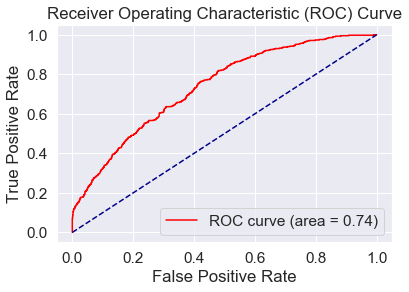

In [73]:
probs = model.predict_proba(x_test)
probs = probs[:,1]

auc = roc_auc_score(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

- ROC-AUC shows the quality of the model's predictions its acceptable.


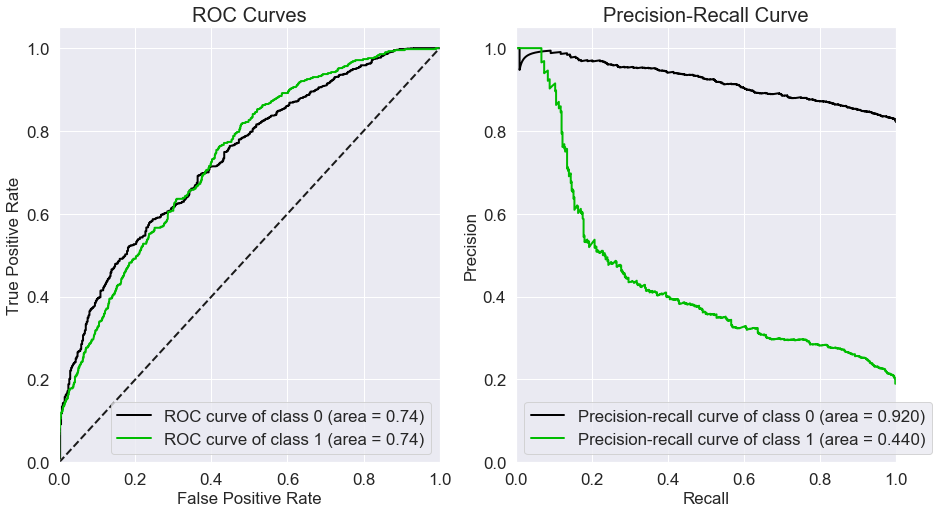

In [74]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(15)
skplt.metrics.plot_roc(y_test, np.column_stack((1-probs, probs)), plot_macro=False, plot_micro=False, ax=axes[0])
skplt.metrics.plot_precision_recall(y_test, np.column_stack((1-probs, probs)), plot_micro=False, ax=axes[1])

<a id="save"></a>
# Saving/Loading the model

In [75]:
# saving the trained model using pickle
pickle.dump(model, open ("./models/saved_model.pkl","wb"))

# loading the trained model
#model = pickle.load ( open("./models/saved_model.pkl", "rb"))

<a id="inter"></a>

# Methods for Prediction (For Integration)
- Ran into integration errors

In [76]:
import pandas as pd
import numpy as np
import pickle

from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing

from sklearn.metrics import classification_report, roc_curve, confusion_matrix, accuracy_score, roc_auc_score, auc

In [77]:
# for testing - import some data
array = [42949673044, 240518168641, 790273982502, 841813590124, 635655159895, 1159641170001, 730144440447]
test = cleaned_df[cleaned_df['bookingID'].isin(array)]
test.to_pickle("./ds/features/test.pkl")

data = pickle.load(open("./ds/features/test.pkl","rb"))

In [78]:
data.shape

(4386, 11)

In [79]:
def dispersion(s):
    # calculate range
    return s.max() - s.min()

In [80]:
def feature_eng(data):
    # required column names
    COL_ACCE = ('acceleration_x', 'acceleration_y', 'acceleration_z')
    COL_GYRO = ('gyro_x', 'gyro_y', 'gyro_z')
    COL_TELE = ('bookingID', 'Accuracy', 'Bearing', 'second', 'Speed', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z')

    bid = data.bookingID.unique()

    # Data Validation 

    if not sorted(data.columns) == sorted(COL_TELE):
        raise Exception('Input columns mismatched! Expected: \n {}'.format(COL_TELE))

    # sort according to bookingID & seconds
    df_use = data.sort_values(['bookingID', 'second']).reset_index(drop=True)

    # drop 'Accuracy' & 'Bearing' to save memory. we don't need these anymore. 
    df_use.drop(['Accuracy', 'Bearing'], axis=1, inplace=True)

    # transform triaxial gyro readings into its first principal components
    pca_gyro = PCA().fit(df_use.loc[:, ['gyro_x', 'gyro_y', 'gyro_z']])
    pca_gyro.explained_variance_ratio_

    # Data Transformation

    # calculate magnitude of acceleration sqrt(acc_x^2 + acc_y^2 + acc_z^2)

    df_use['acceleration'] = np.sqrt((df_use.loc[:, COL_ACCE] ** 2).sum(axis=1))

    df_use['gyro'] = pca_gyro.transform(df_use.loc[:, COL_GYRO])[:,0]

    # Aggregating the features

    feature1 = df_use.groupby('bookingID')['acceleration', 'gyro', 'Speed', 'second'].agg(['mean', 'median', 'std', dispersion]).fillna(0)
    #feature1 = df_use.groupby('bookingID')['acceleration_x','acceleration_y','acceleration_z', 'gyro_x','gyro_y','gyro_z', 'Speed', 'second'].agg(['mean', 'median', 'std', dispersion]).fillna(0)
    feature1.columns = ['_'.join(col) for col in feature1.columns] # rename columns
    feature1.reset_index(inplace=True)

    output = pd.DataFrame(bid, columns=['bookingID'])
    output = output.merge(feature1, how='left', on='bookingID')
  
    return output

In [81]:
response = feature_eng(data)

In [82]:
response.head()

,bookingID,acceleration_mean,acceleration_median,acceleration_std,acceleration_dispersion,gyro_mean,gyro_median,gyro_std,gyro_dispersion,Speed_mean,Speed_median,Speed_std,Speed_dispersion,second_mean,second_median,second_std,second_dispersion
0,42949673044,9.80,9.79,0.35,2.69,-0.01,-0.00,0.10,0.96,3.74,3.59,3.04,9.81,194.30,194.00,112.32,389.00
1,240518168641,10.05,10.02,0.63,7.24,0.00,-0.00,0.11,1.09,14.34,13.12,8.64,27.43,375.00,375.00,216.37,749.00
2,635655159895,9.86,9.87,0.58,4.43,0.00,0.00,0.03,0.21,17.72,18.54,2.46,11.56,225.44,225.50,130.15,450.00
3,730144440447,9.89,9.87,0.59,6.87,-0.00,-0.00,0.10,1.16,4.74,3.94,4.63,15.58,351.19,351.00,203.39,705.00
4,790273982502,9.83,9.79,0.46,3.03,0.02,0.03,0.15,0.95,5.61,5.93,2.97,8.32,74.50,74.50,43.45,149.00


In [83]:
def predict(res):
    model = pickle.load (open("./models/saved_model.pkl", "rb"))
    
    bid = res.bookingID.unique()
    res1 = res.drop(['bookingID'],axis=1)
    
    result = model.predict(res1)
    print("Prediction returned")
    return(result)

In [84]:
predictions = predict(response)

Prediction returned


In [85]:
# for testing and debugging purposes

#dff = pd.DataFrame(data=predictions, columns=["label"])
#dff.to_csv("./ds/labels/test.csv")
#dff['label'].value_counts()

In [86]:
#accuracy_score(y_test, predictions)

<a id="ref"></a>
# References

https://github.com/erichooi/Grab-AI-For-S.E.A./

https://github.com/gerpang/AMLProject_GrabSafety/

https://github.com/yangzhengzhiroy/GrabSafety